In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy import signal

# CHEMIN DES DONNEES

In [3]:
participant = 'P18'
participant_label = 'GM18'
session = 'ses02'
file = f'/crnldata/cmo/multisite/DATA_MANIP/EEG_Lyon_VJ/Data/raw_data/{participant}/signaux/sub{participant_label}_{session}.vhdr' # chemin des données

# CHARGEMENT DES DONNEES

In [4]:
raw = mne.io.read_raw_brainvision(file, preload = True) # lecture des données 
srate = raw.info['sfreq'] # extraction de la fréquence d'échantillonnage
chans = raw.info['ch_names'] # extraction des noms de canaux
extra_eeg_chans = ['ECG','GSR','RespiNasale','RespiVentrale'] # liste des canaux non neuro
eeg_chans = [chan for chan in chans if not chan in extra_eeg_chans] # liste des canaux neuro
print(f'Extra eeg channels = {extra_eeg_chans}')
print(f'EEG channels = {eeg_chans}')
print(f"Fréquence d'échantillonnage = {srate}")

Extracting parameters from /crnldata/cmo/multisite/DATA_MANIP/EEG_Lyon_VJ/Data/raw_data/P18/signaux/subGM18_ses02.vhdr...
Setting channel info structure...


/tmp/ipykernel_176124/3426202482.py:2: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(file, preload = True) # lecture des données
/tmp/ipykernel_176124/3426202482.py:2: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload = True) # lecture des données
/tmp/ipykernel_176124/3426202482.py:2: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (500.00 Hz, Nyquist limit) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload = True) # lecture des données


Reading 0 ... 3297519  =      0.000 ...  3297.519 secs...
Extra eeg channels = ['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
EEG channels = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
Fréquence d'échantillonnage = 1000.0


/tmp/ipykernel_176124/3426202482.py:2: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(file, preload = True) # lecture des données


# FILTRAGE (ou pas) DES DONNEES ET ANALYSE PAR COMPOSANTES INDEPENDANTES (ICA)

In [5]:
raw_eeg = raw.pick_types(eeg = True) # Selectionne les canaux EEG
raw_eeg_for_ica_filtered = raw_eeg.copy() # copie car les fonctions sont appliquées "inplace"
raw_eeg_for_ica_filtered = raw_eeg_for_ica_filtered.filter(1, None, fir_design='firwin', verbose = False) # Filtre passe-haut 1 Hz pour bon fonctionnement de la ICA

ica = mne.preprocessing.ICA(n_components=5) # prépare une ICA

ica.fit(raw_eeg_for_ica_filtered) # Fit la ICA sur les données filtrées

sources_signals = ica.get_sources(raw_eeg_for_ica_filtered).get_data() # extrait les données des composantes ICA en format numpy

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 18.3s.


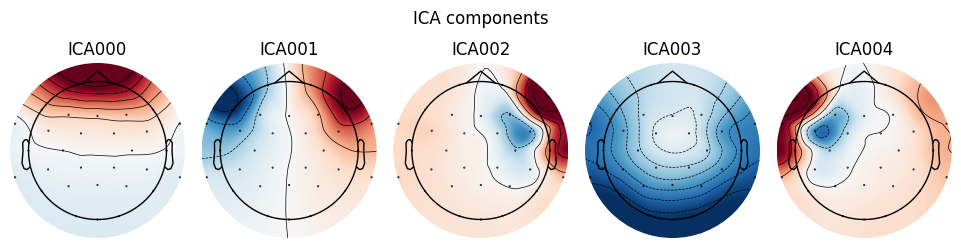

In [6]:
ica.plot_components() # plot la topographie des sources
plt.show()

In [7]:
raw_post_ica_filtered = raw_eeg_for_ica_filtered.copy() 
raw_post_ica_unfiltered = raw_eeg.copy()
ica.apply(raw_post_ica_filtered, exclude = [0]) # exclusion de la composante 0 sur les données filtrées (pour le test)  
ica.apply(raw_post_ica_unfiltered, exclude = [0]) # exclusion de la composante 0 sur les données non filtrées (pour le test)  

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components


<RawBrainVision | subGM18_ses02.eeg, 31 x 3297520 (3297.5 s), ~779.9 MB, data loaded>

In [8]:
pick_chans = ['Fp1','P7']
data_pre_ica_filtered = raw_eeg_for_ica_filtered.get_data(picks = pick_chans) # selectionne données de Fp1 (canal frontal) et P7 (canal pariétal) avant ICA
data_pre_ica_unfiltered = raw_eeg.get_data(picks = pick_chans) # selectionne données de Fp1 (canal frontal) et P7 (canal pariétal) avant ICA
data_post_ica_filtered = raw_post_ica_filtered.get_data(picks = pick_chans) # selectionne données de Fp1 (canal frontal) et P7 (canal pariétal) après ICA
data_post_ica_unfiltered = raw_post_ica_unfiltered.get_data(picks = pick_chans) # selectionne données de Fp1 (canal frontal) et P7 (canal pariétal) après ICA

In [9]:
def center(sig): # centrage du signal en soustrayant sa moyenne
    return sig - np.mean(sig)

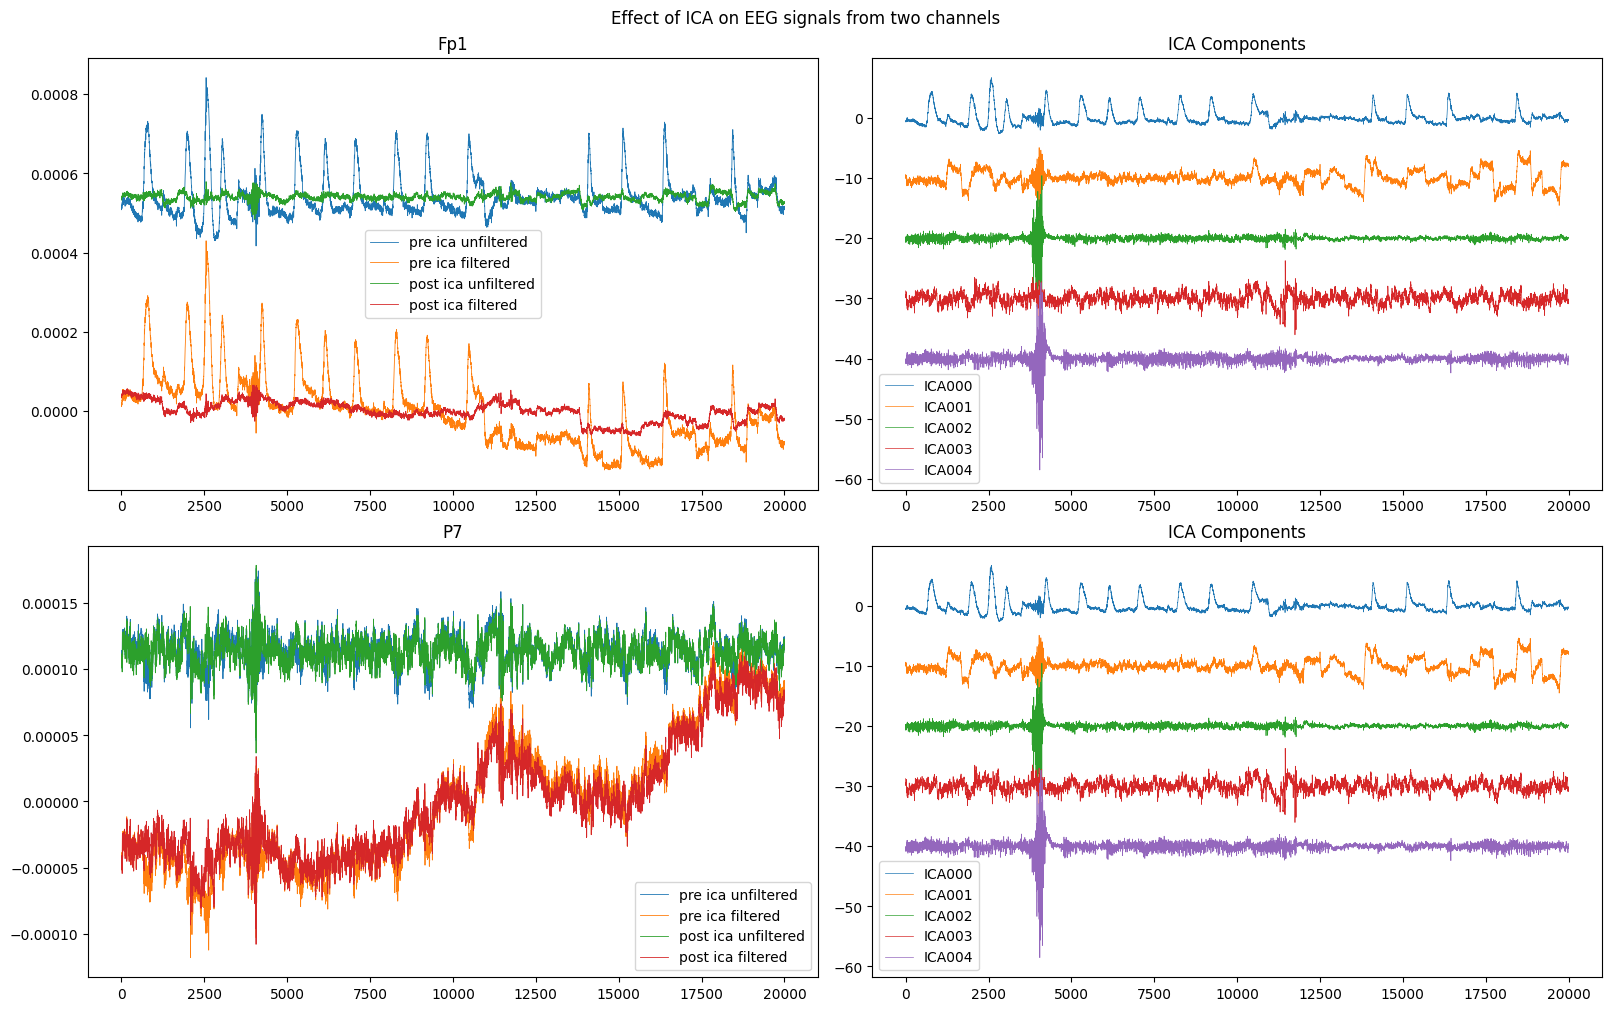

In [10]:
# paramètres d'affichage
start = 50000
stop = 70000
linewidth = 0.6

# figure
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16,10), constrained_layout = True)
fig.suptitle('Effect of ICA on EEG signals from two channels')

for i, chan in enumerate(pick_chans):
    ax = axs[i,0]
    ax.set_title(chan)
    ax.plot(center(data_pre_ica_filtered[i,start:stop]) + 10 * np.std(data_pre_ica_filtered[i,start:stop]), label = 'pre ica unfiltered', linewidth = linewidth)
    ax.plot(center(data_pre_ica_unfiltered[i,start:stop]), label = 'pre ica filtered', linewidth = linewidth)
    ax.plot(center(data_post_ica_filtered[i,start:stop])+10 * np.std(data_pre_ica_filtered[i,start:stop]), label = 'post ica unfiltered', linewidth = linewidth)
    ax.plot(center(data_post_ica_unfiltered[i,start:stop]), label = 'post ica filtered', linewidth = linewidth)
    ax.legend()
    
    ax = axs[i,1]
    ax.set_title('ICA Components')
    for j in range(sources_signals.shape[0]):
        ax.plot(sources_signals[j,start:stop] + j * -10, linewidth = 0.5, label = f'ICA00{j}') # plot les sources ICA
    ax.legend()

plt.show()

In [38]:
def get_wsize(srate, lowest_freq , n_cycles=5): # calcule la taille des fenetres welch sur la base de la fréquence la plus basse désirée et ayant un nombre de cycles = à 5 par fenetres
    nperseg = ( n_cycles / lowest_freq) * srate
    return int(nperseg)

def spectre(sig, srate, lowest_freq, n_cycles = 5):
    nperseg = get_wsize(srate, lowest_freq, n_cycles)
    f, Pxx = signal.welch(sig, fs=srate, nperseg = nperseg, scaling='spectrum')
    return f, Pxx

In [35]:
sources_signals.shape

(5, 3297520)

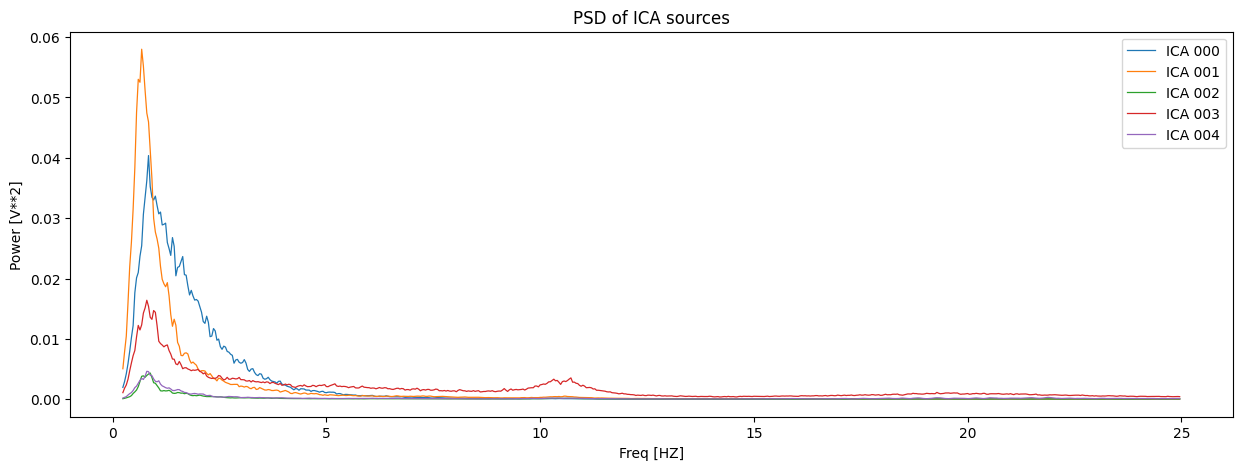

In [43]:
lowest_freq = 0.2 # fréquence la plus basse
lowcut_display = lowest_freq
highcut_display = 25

fig, ax = plt.subplots(figsize = (15,5))

for i in range(sources_signals.shape[0]):
    sig = sources_signals[i,:]
    f, Pxx = spectre(sig, srate, lowest_freq)
    keep_frequencies = (f > lowcut_display) & (f < highcut_display)
    ax.plot(f[keep_frequencies], Pxx[keep_frequencies], label = f'ICA 00{i}', linewidth = 0.9)
    
ax.set_title('PSD of ICA sources')
ax.set_ylabel('Power [V**2]')
ax.set_xlabel('Freq [HZ]')
ax.legend()
plt.show()